# FACS analysis

Flag-YFP-DHFR-puroR lentivirus in HEK293T GCN2KO : all 6 leu codon variants.  Same cells for combined 11 CV lib YFP mRNA/DNA seq experiment.  Used LV2 stock : 250 ul virus per 12 well plate well. Selected with 1.5 ug/ml puro.

* 2 plasmid reporters 
    1. YFP-WT: Flag-YFPwt-DHFRwt
    2. YFP-CTA: Flag-YFPcta-DHFRwt
    3. YFP-CTC: Flag-YFPctc-DHFRwt
    4. YFP-CTT: Flag-YFPctt-DHFRwt
    5. YFP-TTA: Flag-YFPtta-DHFRwt
    6. YFP-TTG: Flag-YFPttg-DHFRwt
* 8 conditions
    1. rich, +/- 10 uM TMP
    2. -leu, +/- 10 uM TMP
    3. -arg, +/- 10 uM TMP (for all - tmp is only for the 24 h time point).
* Measurement voltages: FSC = 280, SSC = 210, FITC = 275

### Analysis Steps
  0. consider mean of fcs/ssc gated population of 20000 events @ for each sample separately
  1. thresholding for reasonable FSC/SSC values and NO fluorescence value based thresholding
  2. rich condition normalization

### Globals

In [1]:
%matplotlib inline
# globals
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from FlowCytometryTools import FCMeasurement

In [2]:
# matplotlib default customizations
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color = ["#CC79A7", "#E69F00", "#D55E00",
               "#0072B2", "#56B4E9", "#009E73"])
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.subplot.hspace'] = 0.5
mpl.rcParams['figure.subplot.wspace'] = 0.5
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

### Experiment Annotations

In [3]:
sampleids = {1: 'YFP-WT Rich TMP 1',
 2: 'YFP-WT -Leu TMP 1',
 3: 'YFP-WT -Arg TMP 1',
 4: 'YFP-CTA Rich TMP 1',
 5: 'YFP-CTA -Leu TMP 1',
 6: 'YFP-CTA -Arg TMP 1',
 7: 'YFP-CTC Rich TMP 1',
 8: 'YFP-CTC -Leu TMP 1',
 9: 'YFP-CTC -Arg TMP 1',
 10: 'YFP-CTT Rich TMP 1',
 11: 'YFP-CTT -Leu TMP 1',
 12: 'YFP-CTT -Arg TMP 1',
 13: 'YFP-TTA Rich TMP 1',
 14: 'YFP-TTA -Leu TMP 1',
 15: 'YFP-TTA -Arg TMP 1',
 16: 'YFP-TTG Rich TMP 1',
 17: 'YFP-TTG -Leu TMP 1',
 18: 'YFP-TTG -Arg TMP 1',
 19: 'YFP-WT Rich NOTMP 1',
 20: 'YFP-CTA Rich NOTMP 1',
 21: 'YFP-CTC Rich NOTMP 1',
 22: 'YFP-CTT Rich NOTMP 1',
 23: 'YFP-TTA Rich NOTMP 1',
 24: 'YFP-TTG Rich NOTMP 1'}

#make sure this is right!



timepoints = {
    'Specimen_001': 12,
    'Specimen_002': 24,
    'Specimen_003': 48,
 }

fsc_threshold = 30000
ssc_threshold = 12500

### Read in data and calculate median and mean after thresholding by FSC and SSC ###

In [4]:
fcsFiles = os.listdir('../fcs_files/')
fcsFiles = ['../fcs_files/' + File for File in fcsFiles if File.endswith('.fcs')]

processeddata = dict()
for File in fcsFiles:
    ID = int( File.split( '/' )[-1].split( '.' )[0].split('_')[-1] )
    sampleid = sampleids[ID]
    time = timepoints[re.search('Specimen_00\d+',File).group()]
    sampleid = sampleid.replace(' ','_') + '_%d'%time # replace space by _
    fcsdata = FCMeasurement(ID= sampleid, datafile=File)
    processeddata[ sampleid ] = dict()
    subset = np.logical_and( fcsdata.data['FSC-A'] > fsc_threshold, fcsdata.data['SSC-A'] > ssc_threshold )
    processeddata[ sampleid ]['fsc_median'] = fcsdata.data['FSC-A'][subset].median()
    processeddata[ sampleid ]['fitc_mean'] = fcsdata.data['FITC-A'][subset].mean()
    processeddata[ sampleid ]['fitc_median'] = fcsdata.data['FITC-A'][subset].median()
    processeddata[ sampleid ]['fitc_q25'] = fcsdata.data['FITC-A'][subset].quantile(q=0.25)    
    processeddata[ sampleid ]['fitc_q75'] = fcsdata.data['FITC-A'][subset].quantile(q=0.75)
    processeddata[ sampleid ]['fsc_q25'] = fcsdata.data['FSC-A'][subset].quantile(q=0.25)    
    processeddata[ sampleid ]['fsc_q75'] = fcsdata.data['FSC-A'][subset].quantile(q=0.75)       
    
data = pd.DataFrame.from_dict( processeddata, orient='index' )
#data

### Calculate Mean, Median and Stddev by Replicates

In [5]:
# create a sample label by removing replicate number
data['samplelabel'] = map( lambda x: '_'.join(x.split('_')[:-2] + [x.split('_')[-1]]), data.index)
# groupby sample label
groupeddata = data.groupby( ['samplelabel'] )
# calcuate median, std, mean of fitc channel across replicates
summarizedData = groupeddata['fitc_mean'].agg([np.mean, np.std, np.median]) ##THIS NEEDS TO BE FIXED

In [6]:
summarizedData

,mean,std,median
samplelabel,,,
YFP-CTA_-Arg_TMP_12,1858.590332,NaN,1858.590332
YFP-CTA_-Arg_TMP_24,2682.507568,NaN,2682.507568
YFP-CTA_-Arg_TMP_48,4702.991699,NaN,4702.991699
YFP-CTA_-Leu_TMP_12,3263.090332,NaN,3263.090332
YFP-CTA_-Leu_TMP_24,5483.535156,NaN,5483.535156
YFP-CTA_-Leu_TMP_48,10350.687500,NaN,10350.687500
YFP-CTA_Rich_NOTMP_24,207.037582,NaN,207.037582
YFP-CTA_Rich_TMP_12,2417.387939,NaN,2417.387939
YFP-CTA_Rich_TMP_24,2954.926514,NaN,2954.926514


### Subtract NoTMP background from TMP samples

In [7]:
tmpsamples = map( lambda x: x.find('NOTMP') == -1, summarizedData.index)
summarizedDataTmp = summarizedData[tmpsamples]
summarizedDataNoTmp = summarizedData[np.logical_not(tmpsamples)]
summarizedDataNoTmp.index = map( lambda x: x.replace('_NOTMP',''), summarizedDataNoTmp.index)
summarizedDataTmp.index = map( lambda x: x.replace('_TMP',''), summarizedDataTmp.index)

In [8]:
summarizedDataNoTmp

,mean,std,median
YFP-CTA_Rich_24,207.037582,NaN,207.037582
YFP-CTC_Rich_24,234.410217,NaN,234.410217
YFP-CTT_Rich_24,265.412720,NaN,265.412720
YFP-TTA_Rich_24,173.298203,NaN,173.298203
YFP-TTG_Rich_24,339.377808,NaN,339.377808
YFP-WT_Rich_24,356.531250,NaN,356.531250


In [9]:
meanSubtractedData = pd.DataFrame()
meanSubtractedData['mean'] = summarizedDataTmp['mean'] - summarizedDataNoTmp['mean']
meanSubtractedData['std'] = np.sqrt(np.square(summarizedDataTmp['std']) + np.square(summarizedDataNoTmp['std']))

### Normalize by the 'Rich' sample for both mean, median and adjust Stddev

In [9]:
def normalize(row, statistic):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])
    return row[1][statistic] / summarizedDataTmp.ix[normalizationsample][statistic]

def normalizestdevmean(row):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])    
    return row[1]['normalizedMean'] * np.sqrt(
                                           np.square(row[1]['std']/row[1]['mean']) +
                                          np.square(summarizedDataTmp.ix[normalizationsample]['std'] / 
                                          summarizedDataTmp.ix[normalizationsample]['mean']) )

for statistic in ['mean']:
    summarizedDataTmp['normalized' + statistic.capitalize()] = map(
        lambda row: normalize(row, statistic), summarizedDataTmp.iterrows()
    )
    
summarizedDataTmp['normalizedStd'] = map( normalizestdevmean, summarizedDataTmp.iterrows())
summarizedDataTmp['normalizedStdErr'] = summarizedDataTmp['normalizedStd'] / np.sqrt(3)
summarizedDataTmp['stderr'] = summarizedDataTmp['std'] / np.sqrt(3)
summarizedDataTmp['samplelabel'] = summarizedDataTmp.index
summarizedDataTmp

/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,mean,std,median,normalizedMean,normalizedStd,normalizedStdErr,stderr,samplelabel
YFP-CTA_-Arg_12,1858.590332,NaN,1858.590332,0.768842,NaN,NaN,NaN,YFP-CTA_-Arg_12
YFP-CTA_-Arg_24,2682.507568,NaN,2682.507568,0.907809,NaN,NaN,NaN,YFP-CTA_-Arg_24
YFP-CTA_-Arg_48,4702.991699,NaN,4702.991699,1.379084,NaN,NaN,NaN,YFP-CTA_-Arg_48
YFP-CTA_-Leu_12,3263.090332,NaN,3263.090332,1.349841,NaN,NaN,NaN,YFP-CTA_-Leu_12
YFP-CTA_-Leu_24,5483.535156,NaN,5483.535156,1.855726,NaN,NaN,NaN,YFP-CTA_-Leu_24
YFP-CTA_-Leu_48,10350.687500,NaN,10350.687500,3.035189,NaN,NaN,NaN,YFP-CTA_-Leu_48
YFP-CTA_Rich_12,2417.387939,NaN,2417.387939,1.000000,NaN,NaN,NaN,YFP-CTA_Rich_12
YFP-CTA_Rich_24,2954.926514,NaN,2954.926514,1.000000,NaN,NaN,NaN,YFP-CTA_Rich_24
YFP-CTA_Rich_48,3410.228760,NaN,3410.228760,1.000000,NaN,NaN,NaN,YFP-CTA_Rich_48
YFP-CTC_-Arg_12,2059.889893,NaN,2059.889893,0.866670,NaN,NaN,NaN,YFP-CTC_-Arg_12


### Plot time series of mean data for 3 conditions and all variants

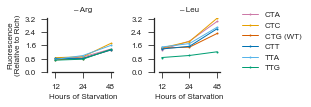

In [12]:

conditions = ['-Arg','-Leu']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0,1,2])
variants = ['CTA','CTC','WT','CTT','TTA','TTG']

fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,2,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataTmp[subset]
        x = xlocations
        y = subsetdata['normalizedMean']
        ax.plot(x, y, marker = 'o', markersize=2, linewidth=1, label = variant.replace('WT','CTG (WT)'))
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 3.25)
    ax.yaxis.set( major_locator = MaxNLocator(5) )
    ax.set_xlabel('Hours of Starvation')
    if axcount == 1:
        ax.set_ylabel('Fluorescence\n(Relative to Rich)')
    if axcount == 2:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'– '))  
    
fig.set_size_inches([3,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170318_normalizedmean__nonotmpsub_all6leu_linegraph_adjcolor_forpaperv2.svg')
fig.savefig('../figures/20170318_normalizedmean__nonotmpsub_all6leu_linegraph_adjcolor_forpaperv2.pdf',bbox_inches='tight')


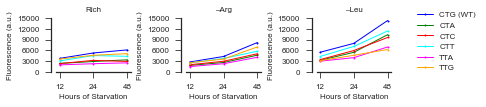

In [10]:

conditions = ['Rich','-Arg','-Leu']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0,1,2])
variants = ['WT','CTA','CTC','CTT','TTA','TTG']

fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,3,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataTmp[subset]
        x = xlocations
        y = subsetdata['mean']
        ax.plot(x, y, label = variant.replace('WT','CTG (WT)'),marker = 'o',markersize=2,linewidth=1)
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 15000)
    ax.yaxis.set( major_locator = MaxNLocator(5) )
    ax.set_xlabel('Hours of Starvation')
    ax.set_ylabel('Fluorescence (a.u.)')
    if axcount == 3:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'–'))  
    
fig.set_size_inches([6,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170318_rawdatamean_nonotmpsub_all6leu_linegraph_forpaper.svg')
#fig.savefig('../figures/20170322_rawdatamean__nonotmpsub_all6arg_linegraph_2redo48.pdf',bbox_inches='tight')


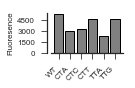

In [29]:
conditions = ['Rich']
times = ['24']
sampleOrder = np.array([52,7,16,25,34,43])
xlocations =np.array([0,1,2,3,4,5])
variants = ['WT','CTA','CTC','CTT','TTA','TTG']

fig = plt.figure()
ax = fig.add_subplot(111)



ax.bar(xlocations, summarizedDataTmp['mean'][sampleOrder], align='center', facecolor = 'grey',edgecolor='black',linewidth=1 )
#ax.errorbar(xlocations, data['relative_s35met'][sampleOrder], 
            #data['sem'][sampleOrder], linestyle='None', color = 'black', elinewidth=0.5, capsize=2, capthick=0.5 )

spineOffset = {'left': 4, 'bottom': 0}   
[ spine.set_position(('outward',spineOffset[loc])) 
     if loc in ['left','bottom'] else spine.set_color('none') 
     for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )
ax.set_ylim(0,5500)
ax.set_xticks(xlocations)
xticklabels= variants
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

ax.set_ylabel( 'Fluoresence')

fig.set_size_inches([1.29,.75])

fig.savefig('../figures/rawdata_rich_plustmp_24h.svg')


In [30]:
summarizedDataNoTmp

,mean,std,median
YFP-CTA_Rich_24,207.037582,NaN,207.037582
YFP-CTC_Rich_24,234.410217,NaN,234.410217
YFP-CTT_Rich_24,265.412720,NaN,265.412720
YFP-TTA_Rich_24,173.298203,NaN,173.298203
YFP-TTG_Rich_24,339.377808,NaN,339.377808
YFP-WT_Rich_24,356.531250,NaN,356.531250


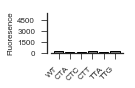

In [31]:
conditions = ['Rich']
times = ['24']
sampleOrder = np.array([5,0,1,2,3,4])
xlocations =np.array([0,1,2,3,4,5])
variants = ['WT','CTA','CTC','CTT','TTA','TTG']

fig = plt.figure()
ax = fig.add_subplot(111)



ax.bar(xlocations, summarizedDataNoTmp['mean'][sampleOrder], align='center', facecolor = 'grey',edgecolor='black',linewidth=1 )
#ax.errorbar(xlocations, data['relative_s35met'][sampleOrder], 
            #data['sem'][sampleOrder], linestyle='None', color = 'black', elinewidth=0.5, capsize=2, capthick=0.5 )

spineOffset = {'left': 4, 'bottom': 0}   
[ spine.set_position(('outward',spineOffset[loc])) 
     if loc in ['left','bottom'] else spine.set_color('none') 
     for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )
ax.set_ylim(0,5500)
ax.set_xticks(xlocations)
xticklabels= variants
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

ax.set_ylabel( 'Fluoresence')

fig.set_size_inches([1.29,.75])

fig.savefig('../figures/rawdata_rich_minustmp_24h.svg')
